# Invoice Digitization Playground

Let's build a workflow to upload a PDF file to a S3 Bucket and parse this file to an Excel file to have it available with the key information. 
The workflow works as follows: 

S3 Bucket upload (.pdf) --> Trigger Lambda Function --> Lambda Processes Requests and dumps .xlsx --> Dump .xlsx file to S3 parsed folder


Before we can install all the relevant lbraries it is important to download the [Pytesseract Binaries](https://digi.bib.uni-mannheim.de/tesseract/), which come with a launch wizard. <br>
Now we can move on with the normal installations <br>
Installations: <br>
source venv/bin/activate<br>
pip install numpy<br>
pip install pandas<br>
pip install pdf2image<br>
pip install cv2<br>
pip install pytesseract<br>

In [3]:
# !source venv/bin/activate
# !python3 -m ipykernel install --user --name=venv
# !python3 -m ensurepip --default-pip
# !pip3 install pdf2image
# !pip3 install numpy
# !pip3 install pandas
# !pip3 install pytesseract
# !pip3 install opencv-python
# !pip3 install matplotlib
# !pip3 install openpyxl
# !pip3 install boto3

  Using cached pdf2image-1.16.0-py3-none-any.whl (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 6.0 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 8.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 10.9 MB/s eta 0:00:0000:0100:01
  Using cached pytz-2022.2.1-py2.py3-none-any.whl (500 kB)


In [1]:
import os
import cv2 # optional only for visualization purposes
import pdf2image
import pandas as pd 
import numpy as np 
import pytesseract
from importlib.metadata import version
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400

In [ ]:
# brew install tesseract
# sudo apt update
# sudo apt install tesseract-ocr
# sudo apt install libtesseract-dev
# pytesseract.pytesseract.tesseract_cmd = "C:\\Users\\lehmanl\\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe"

In [55]:
def extractCharBlock(block, keyWord, end=-1):
    response = block[ (block.find(keyWord) + len(keyWord)) : end]
    return response

## Reading the PDF Invoices

go through all the files in the *Invoice* folder and load them into the files variable

In [56]:
fileDir = os.path.join(os.getcwd(), 'Invoice')
files = []
imgPath = []
for file in os.listdir(fileDir):
    if file.endswith('.pdf'):
        files.append(os.path.join(fileDir, file))
    else: #endswith .jpg
        imgPath.append(os.path.join(fileDir, file))
files

['/Users/mac/Desktop/云计算项目/100-Awesome-AWS-Introduction-Experiments/AWS S3 Trigger Lambda Function Demo/pytesseract-lambda/Invoice/TrainTicket4.pdf',
 '/Users/mac/Desktop/云计算项目/100-Awesome-AWS-Introduction-Experiments/AWS S3 Trigger Lambda Function Demo/pytesseract-lambda/Invoice/TrainTicket2.pdf',
 '/Users/mac/Desktop/云计算项目/100-Awesome-AWS-Introduction-Experiments/AWS S3 Trigger Lambda Function Demo/pytesseract-lambda/Invoice/TrainTicket3.pdf',
 '/Users/mac/Desktop/云计算项目/100-Awesome-AWS-Introduction-Experiments/AWS S3 Trigger Lambda Function Demo/pytesseract-lambda/Invoice/TrainTicket1.pdf']

In [63]:
# files[1].split('\\')[-1][:-4]
files[3].split('\\')[-1][:-4]

'/Users/mac/Desktop/云计算项目/100-Awesome-AWS-Introduction-Experiments/AWS S3 Trigger Lambda Function Demo/pytesseract-lambda/Invoice/TrainTicket1'

In [64]:
files[3]

'/Users/mac/Desktop/云计算项目/100-Awesome-AWS-Introduction-Experiments/AWS S3 Trigger Lambda Function Demo/pytesseract-lambda/Invoice/TrainTicket1.pdf'

## Convert PDFs to Images (.jpg) to work with them

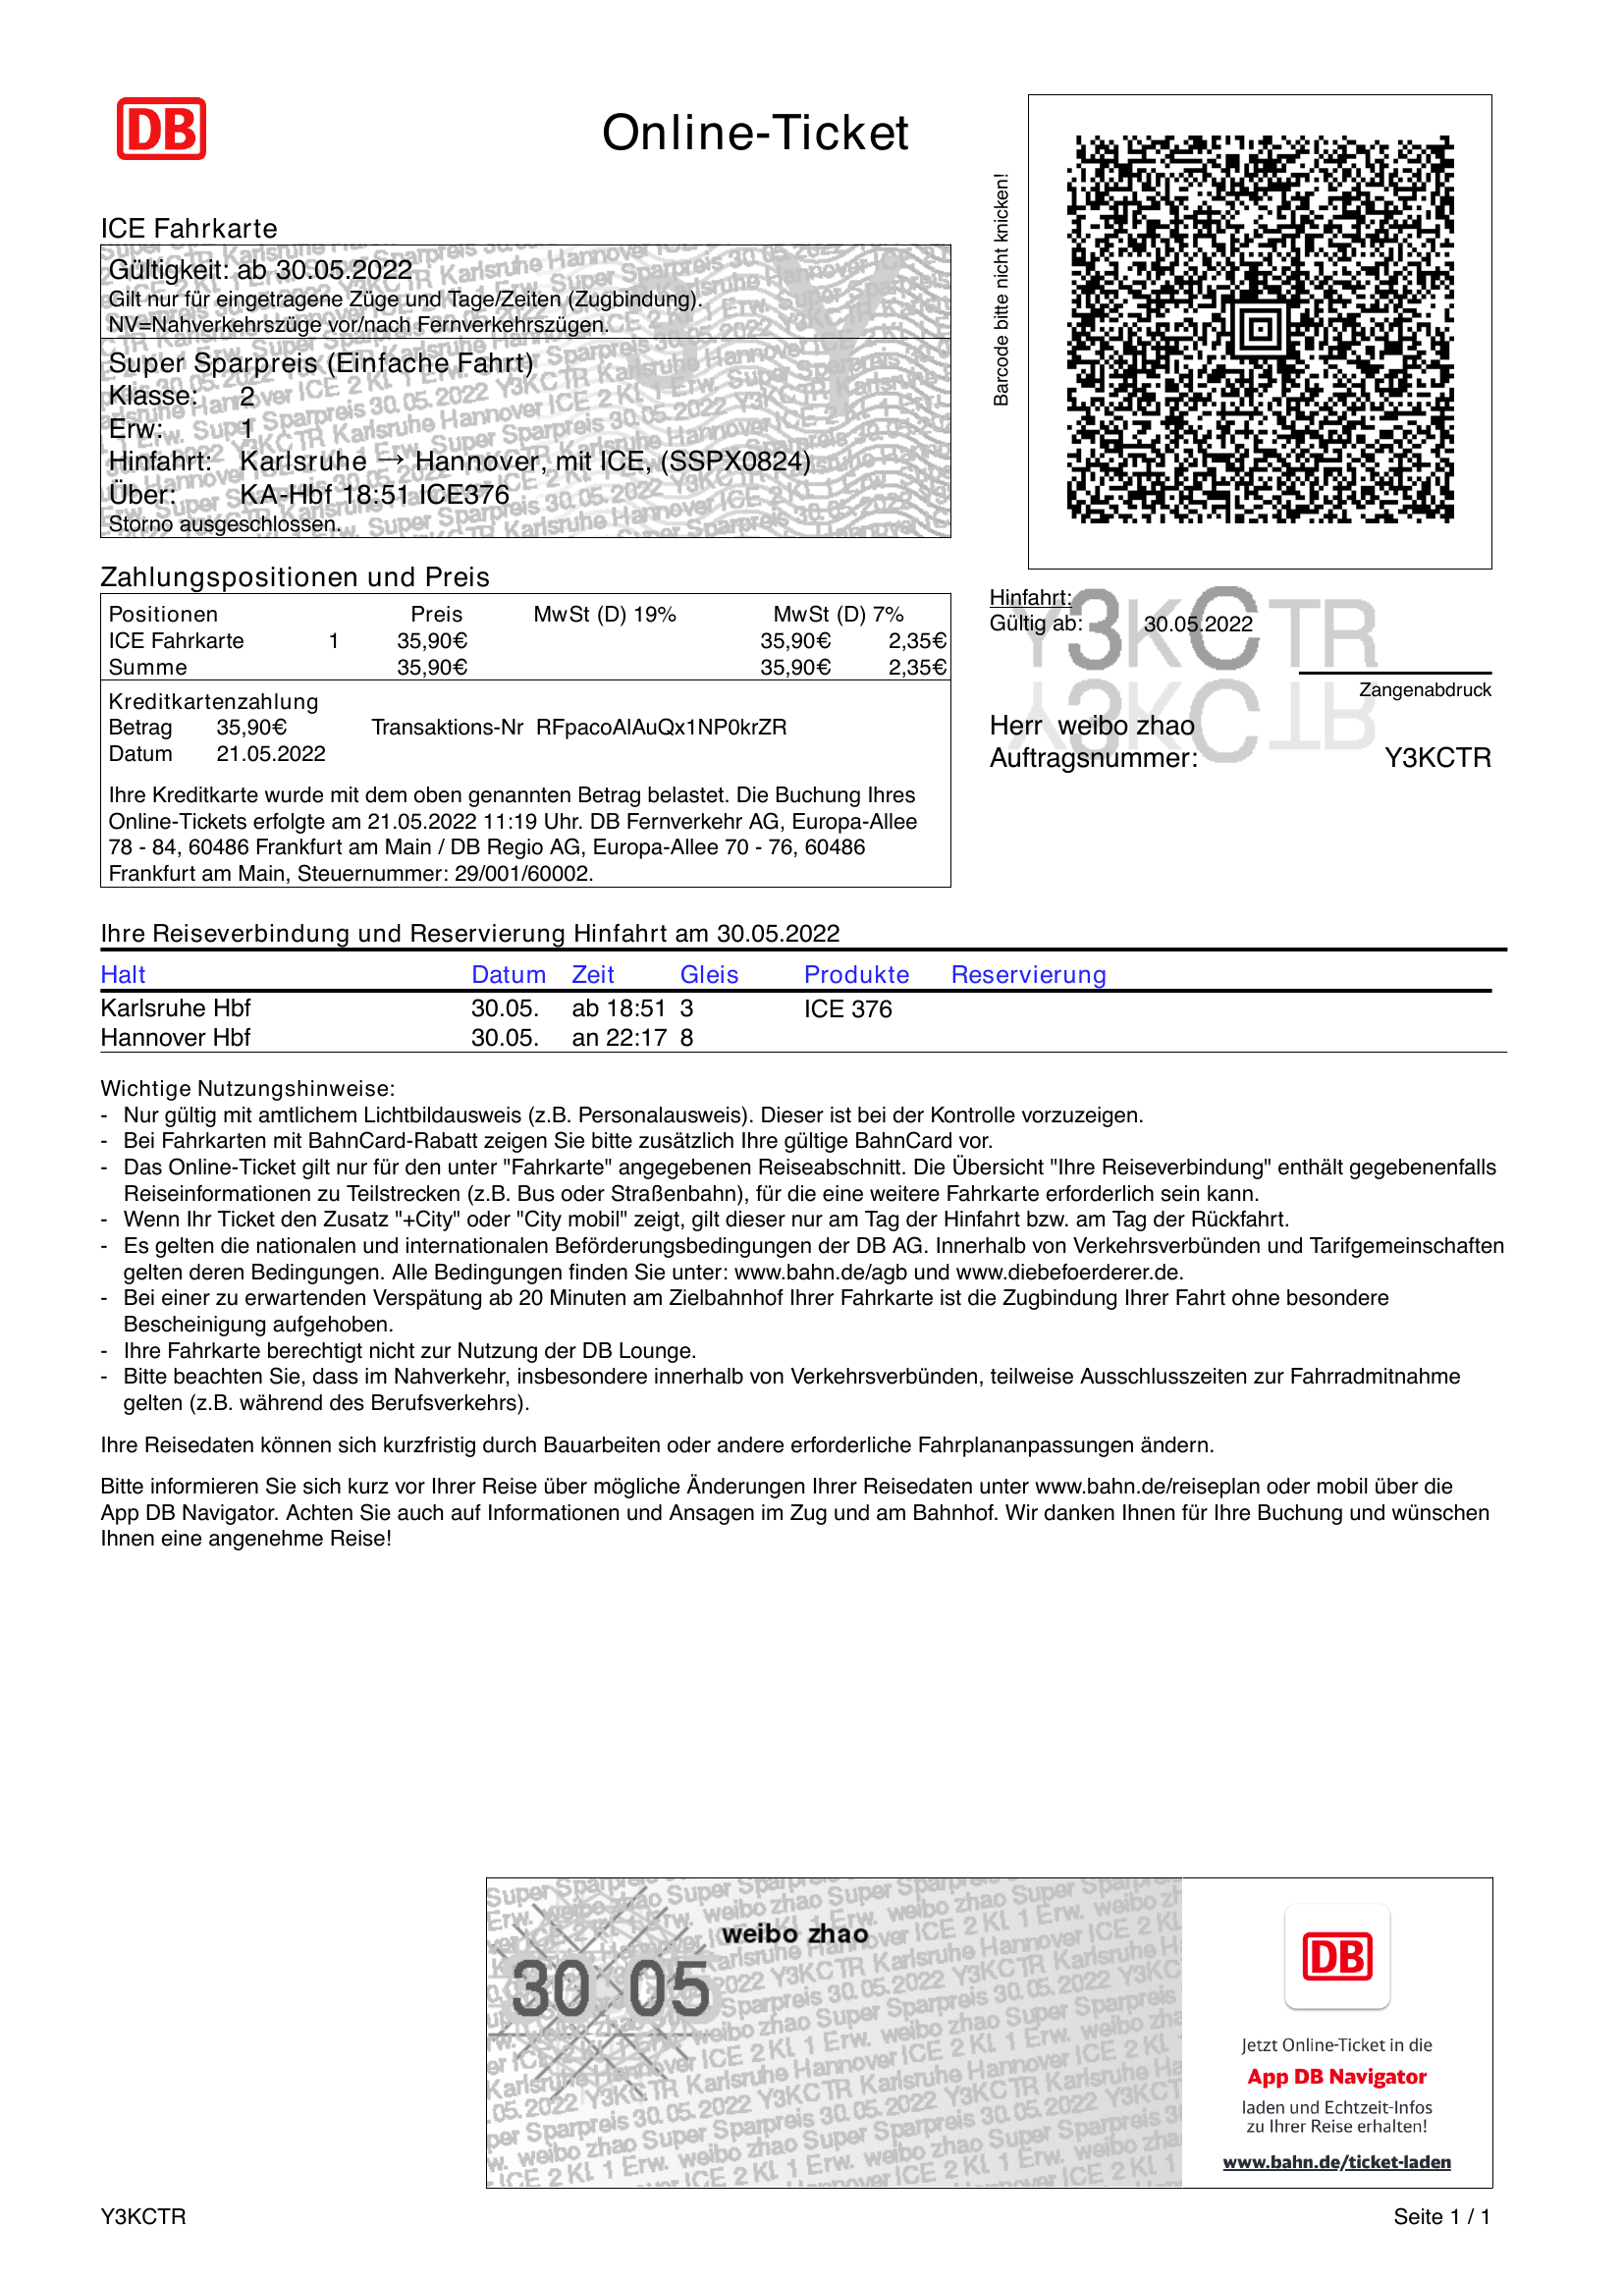

In [65]:
#!brew install poppler
# choco install poppler
# sudo apt-get install poppler-utils
imgs = pdf2image.convert_from_path(files[3])
imgs[0]

## Date and Cost extraction

Let's extract the Amount of the ticket along with the date when it happened

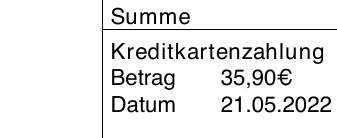

In [66]:
w, h = imgs[0].size # width and height
left = 0
right = w // 4.9
top = (h // 3.5)
bottom = h//2.9
# Crop the image to only get the relevant part of the Deutsche Bahn Invoice
price = imgs[0].crop((left, top, right, bottom))
price

In [11]:
# Run the open-source Optical Character Recognition (OCR) network on the file
costBlock = pytesseract.image_to_string(price)
print(costBlock)

Kreditkartenzahlung
Betrag 35,90€
Datum 21.05.2022



In [183]:
# Extract the Date from the given String Block
lookoutWord = 'Datum'
dateBlock = costBlock[costBlock.find(lookoutWord) + len(lookoutWord) + 1 : -1]
dateBlock

'21.05.2022'

In [13]:
print(extractCharBlock(costBlock, 'Datum'))

 21.05.2022


In [14]:
# Extract the Amount of the given STring Block
lookoutWord = 'Betrag'
Amount = costBlock[(costBlock.find(lookoutWord) + len(lookoutWord) + 1) : (costBlock.find('€') + 1)]
Amount

'35,90€'

In [15]:
print(extractCharBlock(costBlock, 'Betrag', (costBlock.find('€') + 1)))

 35,90€


## Station Extraction 
Let's do the same stuff only for the Start and End station

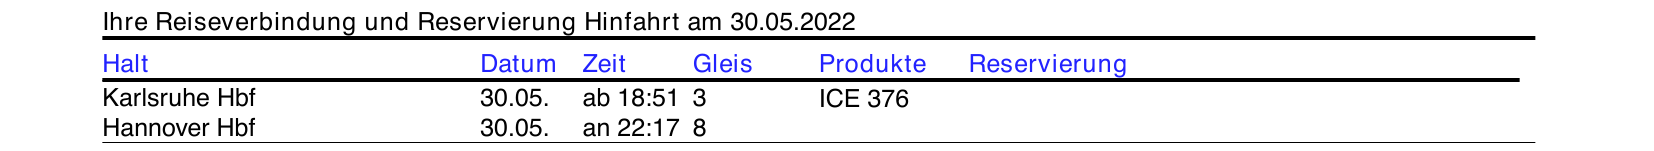

In [16]:
# Extract the Station and ride overview
w, h = imgs[0].size
left = 0
right = w
top = (h // 2.5)
bottom = h//2.15
stops = imgs[0].crop((left, top, right, bottom))
stops

In [17]:
# Run the OCR script to turn the image to strings
stations = pytesseract.image_to_string(stops)
print(stations)

Ihre Reiseverbindung und Reservierung Hinfahrt am 30.05.2022

Halt Datum Zeit Gleis Produkte — Reservierung

Karlsruhe Hbf 30.05. ab 18:51 3 ICE 376
Hannover Hbf 30.05. an 22:17 8




In [67]:
stations2 = stations[stations.find('Halt') :-1]
properFormat = [field for field in stations2.split('\n') if len(field) > 1]
properFormat

['Halt Datum Zeit Gleis Produkte — Reservierung',
 'Karlsruhe Hbf 30.05. ab 18:51 3 ICE 376',
 'Hannover Hbf 30.05. an 22:17 8']

In [19]:
format = extractCharBlock(stations, 'Halt')
properFormat = [field for field in format.split('\n') if len(field) > 1]
properFormat

[' Datum Zeit Gleis Produkte — Reservierung',
 'Karlsruhe Hbf 30.05. ab 18:51 3 ICE 376',
 'Hannover Hbf 30.05. an 22:17 8']

In [20]:
startStation = properFormat[1][: properFormat[1].find('Hbf')]
startStation

'Karlsruhe '

In [21]:
overStation = properFormat[2][: properFormat[2].find('Hbf')]
overStation

'Hannover '

In [22]:
endStation = properFormat[-1][: properFormat[-1].find('Hbf')]
endStation

'Hannover '

## Write to Excel file

dump the exracted KPIs into an Excel file and place it in an S3 Bucket

In [23]:
outputDir = os.path.join(os.getcwd(), "ExcelFile")
header = ["Datum", "Kosten", "Startbahhof", "Zwischenstation", "Endbahnhof"]
entries = [dateBlock, Amount, startStation, overStation, endStation]#['18.02.2020', '25,45€', 'Munchen ', 'Stuttgart ', 'Pforzheim ']
#entries = [[entry] for entry in entries]
entries = np.array([[entry] for entry in entries])
header, entries

(['Datum', 'Kosten', 'Startbahhof', 'Zwischenstation', 'Endbahnhof'],
 array([['21.05.202'],
        ['35,90€'],
        ['Karlsruhe '],
        ['Hannover '],
        ['Hannover ']], dtype='<U10'))

In [24]:
df = pd.DataFrame(entries.T, columns=header)
df

,Datum,Kosten,Startbahhof,Zwischenstation,Endbahnhof
0,21.05.202,"35,90€",Karlsruhe,Hannover,Hannover


Create an Excel file in case this is not yet present. <br>
Otherwise read the existing Excel file and append a new row with the latest entry to it.

In [25]:
if os.listdir(outputDir) == [] :
    print("Creating new File")
    df.to_excel(os.path.join(outputDir, "TrainCost.xlsx"), index=False)
else:
    print("Read existing File")
    df = pd.read_excel(os.path.join(outputDir, "TrainCost.xlsx"))
    entries_df = pd.DataFrame(entries.T, columns=header)
    df = pd.concat([df, entries_df], ignore_index=True)
    df.to_excel(os.path.join(outputDir, "TrainCost.xlsx"), index=False)
    print("Successfully updated the Excel File ")
df

Read existing File
Successfully updated the Excel File 


,Datum,Kosten,Startbahhof,Zwischenstation,Endbahnhof
0,21.05.202,"35,90€",Karlsruhe,Hannover,Hannover
1,21.05.202,"35,90€",Karlsruhe,Hannover,Hannover
2,21.05.202,"35,90€",Karlsruhe,Hannover,Hannover


In [26]:
# install missing package with the proper Python kernel
import sys
!{sys.executable} -m pip install openpyxl
import openpyxl
version('openpyxl')

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


'3.0.10'

In [27]:
df_1 = df.isin(df.values[0])
df_1

,Datum,Kosten,Startbahhof,Zwischenstation,Endbahnhof
0,True,True,True,True,True
1,True,True,True,True,True
2,True,True,True,True,True


In [28]:
counter = 0
for i in range(len(df_1.values)):
    if False in df_1.values[i]:
        counter += 1
if counter == len(df_1.values):
    print("Entry does not exist ... appending it to the DataFrame")
    # df = pd.concat([df2, df3], ignore_index=True)
else:
    print("Entry does exist ... ")

Entry does exist ... 


In [29]:
df.to_excel(os.path.join(outputDir, "TrainCost.xlsx"), index=False)

## Write to S3 

In [30]:
import boto3
s3 = boto3.resource('s3')

In [31]:
bucket_name = 'trainticketdemo'
filename = 'TrainCost.xlsx'
key = 'invoice/' + filename

In [32]:
s3.Bucket(bucket_name).upload_file(os.path.join(outputDir, filename), key)

## Generalizing Everything

In [114]:
imgs = pdf2image.convert_from_path(files[2])
d = pytesseract.image_to_data(imgs[0], output_type=pytesseract.Output.DICT)

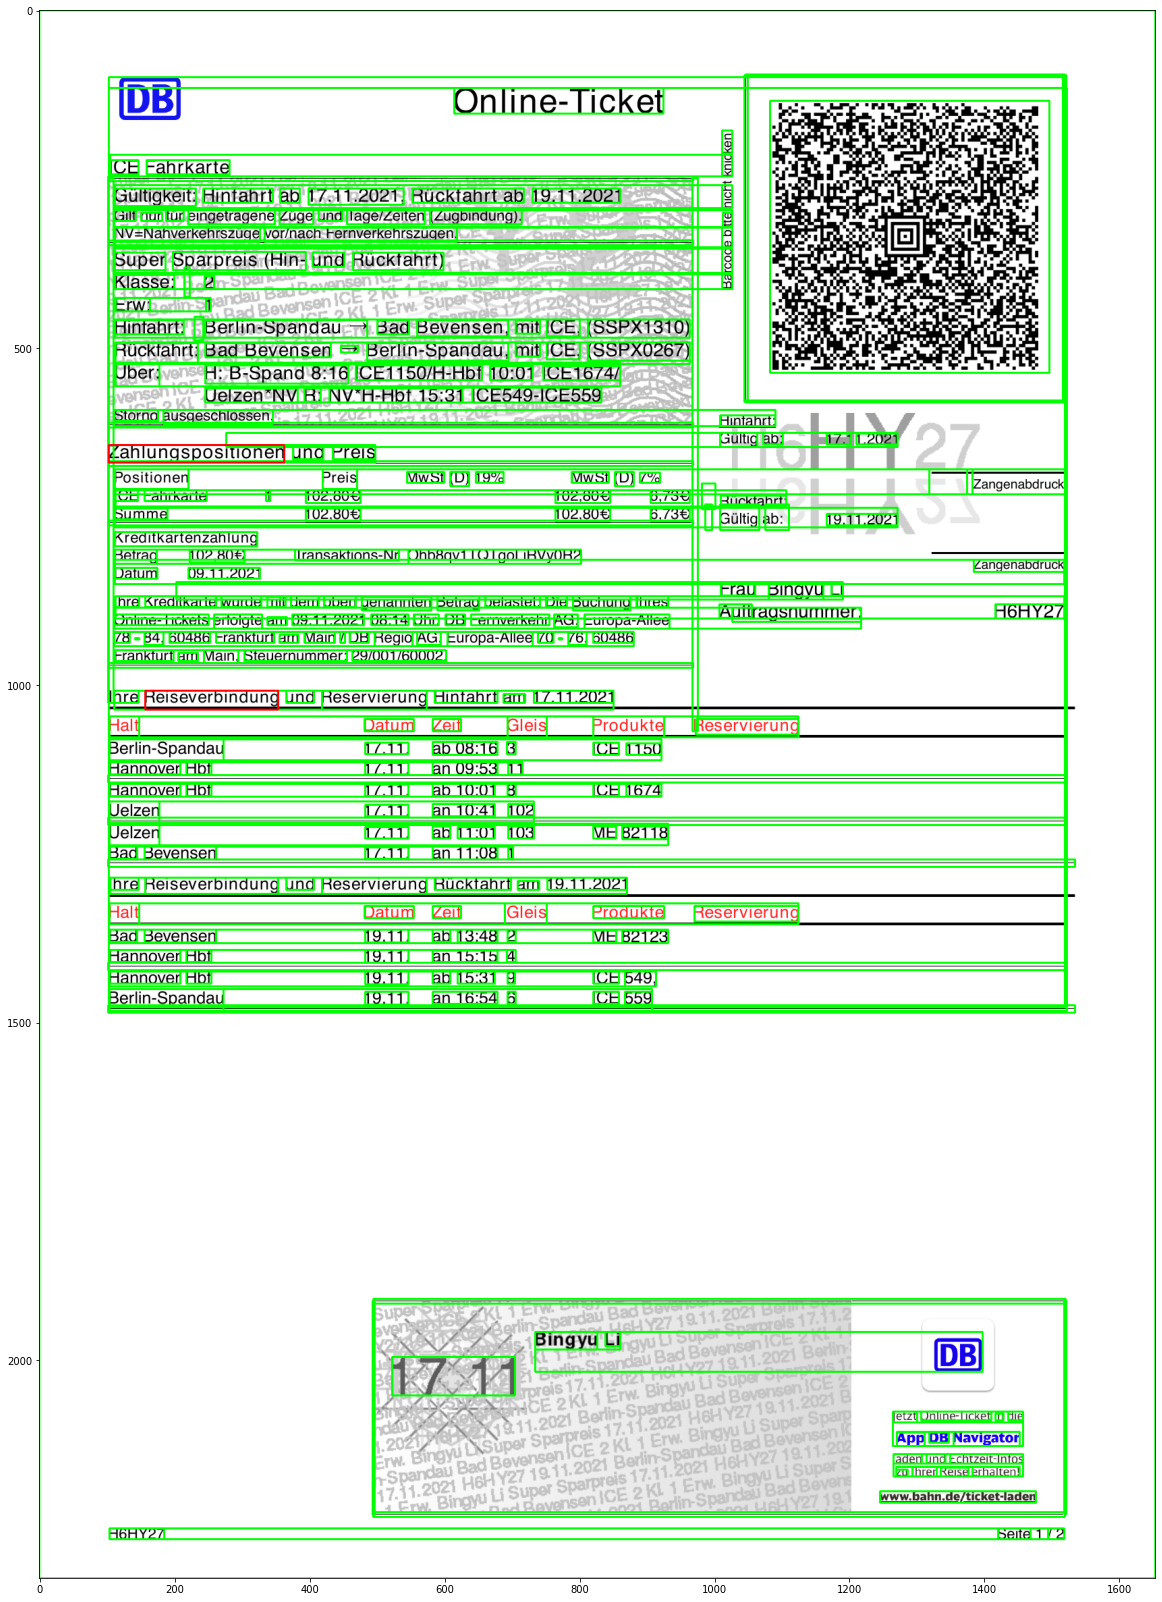

In [115]:
img2 = imgs[0].convert('RGB')
img2 = np.array(img2) 

n_boxes = len(d['level'])
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    if i == d['text'].index('Zahlungspositionen'):
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 2)
    if i == d['text'].index('Reiseverbindung'):
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
# The important part - Correct BGR to RGB channel
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# Plot
plt.figure(figsize = (20,40))
plt.imshow(img2)

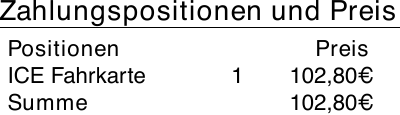

In [116]:
idx = d['text'].index('Zahlungspositionen')
idxEND = d['text'].index('Summe')
(x, y, w, h) =  (d['left'][idx], d['top'][idx], d['width'][idx], d['height'][idx])
(h2, y2) =  (d['height'][idxEND], d['top'][idxEND])
#crop_img = img[ y : y2 + h2 + 5 , x : x + 400 ]
#plt.imshow(crop_img)
image = imgs[0].crop((x, y, x+400, y2+h2+5))
image

In [117]:
netCost = pytesseract.image_to_string(image)
print(netCost)

Zanlungspositionen und Preis

Positionen Preis
ICE Fahrkarte 1 102,80€
Summe 102,80€



In [118]:
amount = netCost[ (netCost.find('Summe') + len('Summe') + 1) : -2]
amount

'102,80'

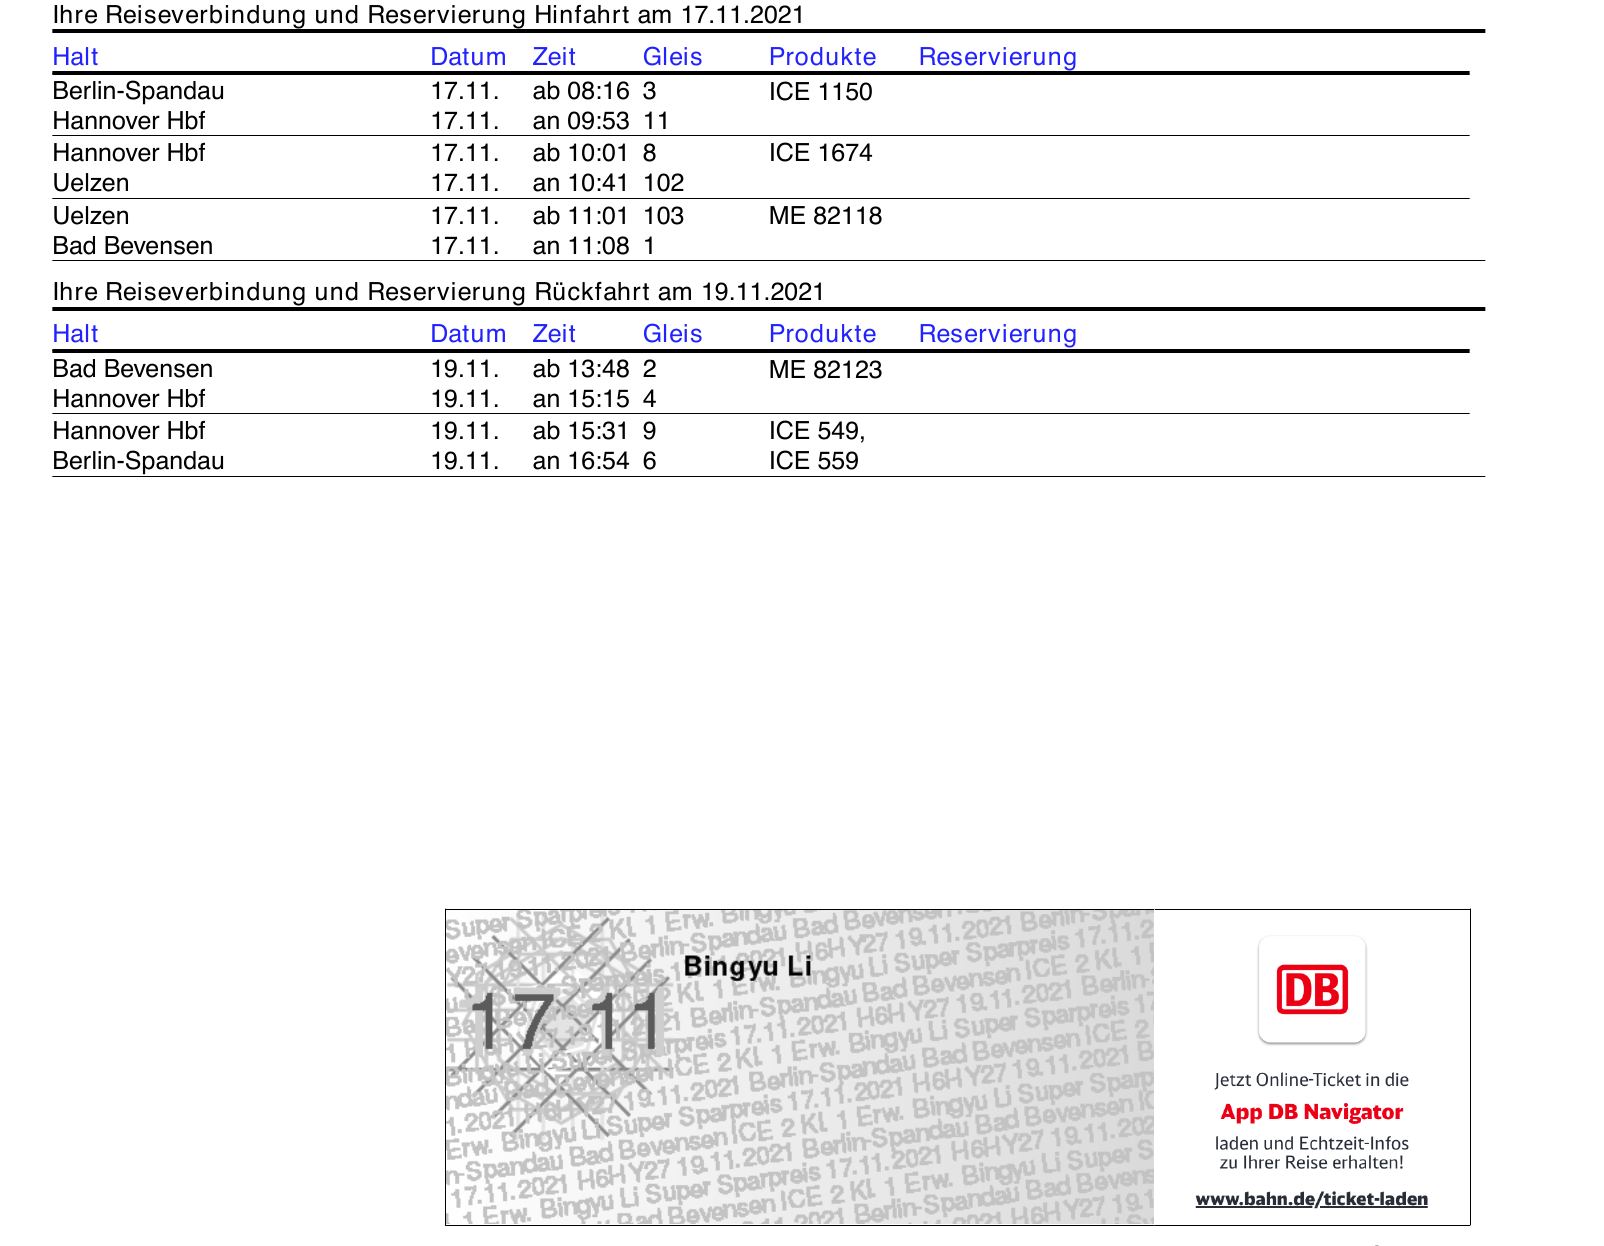

In [119]:
idx = d['text'].index('Reiseverbindung')
try:
    idxEND = d['text'].index('Wichtige')
except ValueError:
    idxEND = d['text'].index('Seite')
(x, y) =  (d['left'][idx], d['top'][idx])
(h2, y2) =  (d['height'][idxEND], d['top'][idxEND])
#crop_img = img[ y - 5 : y2 , 50 : img.shape[1] ]
#plt.imshow(crop_img)
imageDest = imgs[0].crop((50, y-5, imgs[0].size[0], y2))
imageDest

In [121]:
# Run the OCR script to turn the image to strings
stations = pytesseract.image_to_string(imageDest)
if "www.bahn.de/ticket-laden" in stations: 
    stations = '\n'.join(map(str,stations.split("\n")[:-11]))
print(stations)

Ihre Reiseverbindung und Reservierung Hinfahrt am 17.11.2021

Halt Datum Zeit Gleis Produkte — Reservierung
Berlin-Spandau 17.11. ab08:16 3 ICE 1150

Hannover Hbf 17.11. an09:53 11

Hannover Hbf 17.11. ab10:01 8 ICE 1674

Uelzen 17.11. an10:41 102

Uelzen 17.11. ab 11:01 103 ME 82118

Bad Bevensen 17.11. an11:08 1

Ihre Reiseverbindung und Reservierung Rickfahrt am 19.11.2021

Halt Datum Zeit Gleis Produkte —Reservierung
Bad Bevensen 19.11. ab 13:48 2 ME 82123

Hannover Hbf 19.11. an15:15 4

Hannover Hbf 19.11. ab 15:31 9 ICE 549,

Berlin-Spandau 19.11. an16:54 6 ICE 559



In [122]:
def stations_from_list(stationsList, keyWord='Hbf'):
        stops = []
        startStation, middleStation, endStation = '', '', ''
        for i in range(len(stationsList)):
            idx = stationsList[i].find(keyWord)
            if stationsList[i][ : idx - 1] not in stops:
                stops.append(stationsList[i][ : idx - 1])
        if len(stops) > 2: # there was an chnageover, thus a middle station
            startStation 	= stops[0]
            middleStation 	= stops[1]
            endStation 	= stops[-1]
        else: # no middle station
            startStation 	= stops[0]
            endStation 	= stops[-1]
        print(startStation, middleStation, endStation)

In [123]:
# def exract_Stations(croppedImg, keyWord='Halt'):
#     stations = pytesseract.image_to_string(croppedImg)
def exract_Stations(stations, keyWord='Halt'):
    stations = extractCharBlock(stations, keyWord)
    properStations = [station for station in stations.split('\n') if len(station) > 1]
    del properStations[0]
    
    ## Check whether there was also a retunr train booked
    if any('fahrt' in entry for entry in properStations):
        returnDate = [entry[entry.find('fahrt') + 9 : entry.find('fahrt') + 19] for entry in properStations if 'fahrt' in entry][0]
        arrivalTrain = []
        returnTrain = []
        for i in range(len(properStations)): 
            if 'fahrt' in properStations[i]:
                arrivalTrain = properStations[ : i]
                returnTrain  = properStations[i+2 : ] # skip the Rueckfahrt and Halt, Datum rows and just take stations
                break
        stations_from_list(arrivalTrain)
        stations_from_list(returnTrain)
    else:
        stations_from_list(properStations)

In [124]:
# exract_Stations(imageDest)
exract_Stations(stations)

Berlin-Spandau 17.11. ab08:16 3 ICE 11 Hannover Bad Bevensen 17.11. an11:08
Bad Bevensen 19.11. ab 13:48 2 ME 821 Hannover Berlin-Spandau 19.11. an16:54 6 ICE 5


## Demonstartion of the Functions

In [85]:
stations = pytesseract.image_to_string(imageDest)
stations

'Ihre Reiseverbindung und Reservierung Hinfahrt am 18.06.2021\n\nHalt Datum Zeit Gleis Produkte — Reservierung\nK6ln Hbf 18.06. ab07:47 7 ICE 91\n\nNurnberg Hbf 18.06. an12:13 9\n\nNurnberg Hbf 18.06. ab12:49 2 $1\n\nErlangen-Bruck 18.06. an13:08 3\n\nIhre Reiseverbindung und Reservierung Riickfahrt am 18.06.2021 0\nHalt Datum Zeit Gleis Produkte — Reservierung\nErlangen-Bruck 18.06. ab17:24 2 $1\n\nNurnberg Hbf 18.06. an17:48 3\n\nNurnberg Hbf 18.06. ab17:56 7 ICE 528\nFrankfurt(Main)Hbf 18.06. an 20:04 8\n\nFrankfurt(Main)Hbf 18.06. ab 20:35 6 ICE 90\n\nK6ln Hbf 18.06. an 22:59 4A-C\n\n{ 8 06 Weibo Zhao\n\nJetzt Online-Ticket in die\nApp DB Navigator\n\nladen und Echtzeit-Infos\nzu Ihrer Reise erhalten!\n\nwww.bahn.de/ticket-laden\n\n'

In [125]:
# first part of the exract_Stations
word = 'Halt'
route = stations[ (stations.find(word)) : (-1)]
route = [ entry for entry in route.split('\n') if len(entry) > 1]
del route[0]
route

['Berlin-Spandau 17.11. ab08:16 3 ICE 1150',
 'Hannover Hbf 17.11. an09:53 11',
 'Hannover Hbf 17.11. ab10:01 8 ICE 1674',
 'Uelzen 17.11. an10:41 102',
 'Uelzen 17.11. ab 11:01 103 ME 82118',
 'Bad Bevensen 17.11. an11:08 1',
 'Ihre Reiseverbindung und Reservierung Rickfahrt am 19.11.2021',
 'Halt Datum Zeit Gleis Produkte —Reservierung',
 'Bad Bevensen 19.11. ab 13:48 2 ME 82123',
 'Hannover Hbf 19.11. an15:15 4',
 'Hannover Hbf 19.11. ab 15:31 9 ICE 549,',
 'Berlin-Spandau 19.11. an16:54 6 ICE 559']

In [126]:
#stations from list function
stops = []
for i in range(len(route)):
    idx = route[i].find('Hbf')
    if route[i][: idx - 1] not in stops:
        stops.append(route[i][: idx - 1])
stops

['Berlin-Spandau 17.11. ab08:16 3 ICE 11',
 'Hannover',
 'Uelzen 17.11. an10:41 1',
 'Uelzen 17.11. ab 11:01 103 ME 821',
 'Bad Bevensen 17.11. an11:08',
 'Ihre Reiseverbindung und Reservierung Rickfahrt am 19.11.20',
 'Halt Datum Zeit Gleis Produkte —Reservieru',
 'Bad Bevensen 19.11. ab 13:48 2 ME 821',
 'Berlin-Spandau 19.11. an16:54 6 ICE 5']

In [127]:
stopper = [] 
test = [stopper.append(route[i][: route[i].find('Hbf') - 1]) for i in range(len(route)) if route[i][: route[i].find('Hbf') - 1] not in stopper]
stopper

['Berlin-Spandau 17.11. ab08:16 3 ICE 11',
 'Hannover',
 'Uelzen 17.11. an10:41 1',
 'Uelzen 17.11. ab 11:01 103 ME 821',
 'Bad Bevensen 17.11. an11:08',
 'Ihre Reiseverbindung und Reservierung Rickfahrt am 19.11.20',
 'Halt Datum Zeit Gleis Produkte —Reservieru',
 'Bad Bevensen 19.11. ab 13:48 2 ME 821',
 'Berlin-Spandau 19.11. an16:54 6 ICE 5']

In [128]:
route

['Berlin-Spandau 17.11. ab08:16 3 ICE 1150',
 'Hannover Hbf 17.11. an09:53 11',
 'Hannover Hbf 17.11. ab10:01 8 ICE 1674',
 'Uelzen 17.11. an10:41 102',
 'Uelzen 17.11. ab 11:01 103 ME 82118',
 'Bad Bevensen 17.11. an11:08 1',
 'Ihre Reiseverbindung und Reservierung Rickfahrt am 19.11.2021',
 'Halt Datum Zeit Gleis Produkte —Reservierung',
 'Bad Bevensen 19.11. ab 13:48 2 ME 82123',
 'Hannover Hbf 19.11. an15:15 4',
 'Hannover Hbf 19.11. ab 15:31 9 ICE 549,',
 'Berlin-Spandau 19.11. an16:54 6 ICE 559']

In [129]:
returnDate = [entry[entry.find('fahrt') + len('fahrt') + 4 : entry.find('fahrt') + len('fahrt') + 14] for entry in route if 'fahrt' in entry]
returnDate

['19.11.2021']

In [131]:
arrivalTrain = []
returnTrain = []
if any('fahrt' in entry for entry in route):
    for i in range(len(route)):
        if 'fahrt' in route[i]:
            arrivalTrain = route[:i]
            returnTrain = route[i + 2:]
            break
arrivalTrain, returnTrain

(['Berlin-Spandau 17.11. ab08:16 3 ICE 1150',
  'Hannover Hbf 17.11. an09:53 11',
  'Hannover Hbf 17.11. ab10:01 8 ICE 1674',
  'Uelzen 17.11. an10:41 102',
  'Uelzen 17.11. ab 11:01 103 ME 82118',
  'Bad Bevensen 17.11. an11:08 1'],
 ['Bad Bevensen 19.11. ab 13:48 2 ME 82123',
  'Hannover Hbf 19.11. an15:15 4',
  'Hannover Hbf 19.11. ab 15:31 9 ICE 549,',
  'Berlin-Spandau 19.11. an16:54 6 ICE 559'])

In [148]:
arrivalTrain[0]

'Berlin-Spandau 17.11. ab08:16 3 ICE 1150'

In [151]:
import re
def get_station_name(station):
    station_name = station[:re.search(r"\d", station).start()-1]
    return station_name

In [158]:
stops = []
for i in arrivalTrain:
    station_name = get_station_name(i)
    if station_name not in stops:
        stops.append(station_name)
stops

['Berlin-Spandau', 'Hannover Hbf', 'Uelzen', 'Bad Bevensen']

In [159]:
stops = []
for i in returnTrain:
    station_name = get_station_name(i)
    if station_name not in stops:
        stops.append(station_name)
stops

['Bad Bevensen', 'Hannover Hbf', 'Berlin-Spandau']

In [133]:
stops = []
for i in range(len(returnTrain)):
    idx = returnTrain[i].find('Hbf')
    if returnTrain[i][: idx - 1] not in stops:
        stops.append(returnTrain[i][: idx - 1])
stops

['Bad Bevensen 19.11. ab 13:48 2 ME 821',
 'Hannover',
 'Berlin-Spandau 19.11. an16:54 6 ICE 5']

## DataFrame Magic

In [184]:
header = ["Date", "Cost","Start Station", "Transfer Station", "Terminal Station"]
entries = np.array([[dateBlock, Amount]+stops[:3]])
df = pd.DataFrame(entries, columns=header)
df

,Date,Cost,Start Station,Transfer Station,Terminal Station
0,21.05.2022,"35,90€",Bad Bevensen,Hannover Hbf,Berlin-Spandau


In [185]:
test = ['18.02.2020', '25,45€', 'Munchen ', 'Stuttgart ', 'Pforzheim ']
test = np.array([[entry] for entry in test])
test.T

array([['18.02.2020', '25,45€', 'Munchen ', 'Stuttgart ', 'Pforzheim ']],
      dtype='<U10')

In [186]:
arr = np.vstack([entries, test.T])
df2 = pd.DataFrame(arr, columns=header)
df2

,Date,Cost,Start Station,Transfer Station,Terminal Station
0,21.05.2022,"35,90€",Bad Bevensen,Hannover Hbf,Berlin-Spandau
1,18.02.2020,"25,45€",Munchen,Stuttgart,Pforzheim


In [180]:
entries

array([['21.05.202', '35,90€', 'Bad Bevensen', 'Hannover Hbf',
        'Berlin-Spandau']], dtype='<U14')

In [181]:
a = np.array([ ['Mun'], [99], [33], [332], [11] ])
a.T

array([['Mun', '99', '33', '332', '11']], dtype='<U21')

## Class Usage

1.) Create Class with path/to/invoices <br/>
2.) Build And Set Directories if not existent <br/>
3.) Extract Files<br/>
3.) ConvertPDF2Image<br/>
4.) Image To Data to get the cropped Images (priceImg, destinationImg)<br/>
5.) Extract Key Information returns a DataFrame<br/>
6.) Add Delta in DataFrames<br/>
7.) Write to S3 bucket<br/>

In [139]:
invoicing = InvoiceDigitization(os.path.join(os.getcwd(), 'Invoice'))
invoicing.Build_And_Set_Directories()
invoicing.Extract_Files()

final_df = pd.read_excel(os.path.join(invoicing.outputDir, "TrainCost.xlsx"))
for i in range(len(invoicing.invoices)):
    invoicing.invoiceImgs = invoicing.Convert_PDF2Image(invoicing.invoices[i])
    invoicing.Image_To_Data(invoicing.invoiceImgs[0])
    df = invoicing.Extract_Key_Information()
    final_df = invoicing.Add_Delta_In_Dataframes(final_df, df, True)
print(final_df)
invoicing.Write_To_S3("TrainCost.xlsx")

## Showing the Image
#invoicing.destinationImg.show()
#invoicing.priceImg.show()
#invoicing.invoiceImgs[0].show()

NameError: name 'InvoiceDigitization' is not defined